In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tqdm

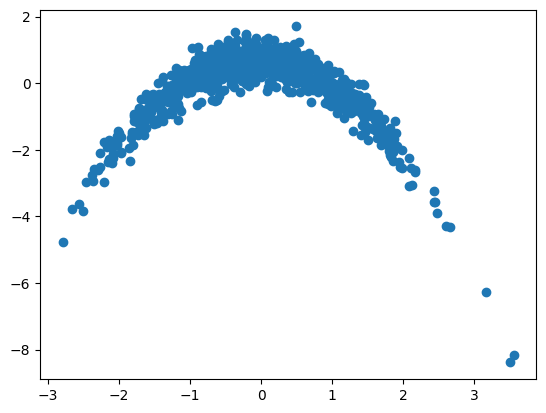

In [2]:
# target distribution q_D
N = 1000
Xs = np.random.randn(2 * N).reshape(N, 2)
Xs[:, 1] -= 2 * Xs[:, 0] ** 2
# it is alweays a good idea for diffusion to normalize data to zero mean, unit variance
Xs = (Xs - np.mean(Xs, axis=0).reshape(1, -1)) / np.std(Xs, axis=0).reshape(1, -1)
plt.figure()
plt.scatter(Xs[:, 0], Xs[:, 1])
plt.show()

In [3]:
# neural network to learn epsilon(x_t,t). you can play around with it, but we added it for convenience
# note that this networks expects normalized values of t in 0 to 1. so divide your time index by T.
class Net(nn.Module):
    def __init__(self, num_latent_features=32, num_embedding_features=16):
        super().__init__()
        self.num_embedding_features = num_embedding_features
        self.num_latent_features = num_latent_features
        self.fc_in = nn.Linear(2, num_latent_features)
        self.fc_emb = nn.Linear(num_embedding_features, num_latent_features)
        self.fc1 = nn.Linear(num_latent_features, num_latent_features)
        self.fc2 = nn.Linear(num_latent_features, num_latent_features)
        self.fc_out = nn.Linear(num_latent_features, 2)

    def embedding(self, t):
        # We assume that t is a n-dimensional vector with values in [0,1]
        # each element in t gives the time for each element in the batch
        num_frequencies = self.num_embedding_features // 2
        frequencies = torch.logspace(
            0, 3, num_frequencies, device=t.device, dtype=t.dtype
        )
        cos_feats = torch.cos(2 * np.pi * frequencies.unsqueeze(0) * t.unsqueeze(1))
        sin_feats = torch.sin(2 * np.pi * frequencies.unsqueeze(0) * t.unsqueeze(1))
        return torch.hstack([cos_feats, sin_feats])

    def forward(self, x, t):
        t_embedding = self.embedding(t)
        # Create sinusoidal features and apply the silu activation
        t_embedding = torch.nn.functional.silu(self.embedding(t))

        # linear combination of space and time features
        x = F.silu(self.fc_in(x) + self.fc_emb(t_embedding))
        # now apply a simple feed forward network with relu activations.
        # note: we skip dropout for simplicity.
        x = F.silu(self.fc1(x))
        x = F.silu(self.fc2(x))
        # transform back
        x = self.fc_out(x)
        return x

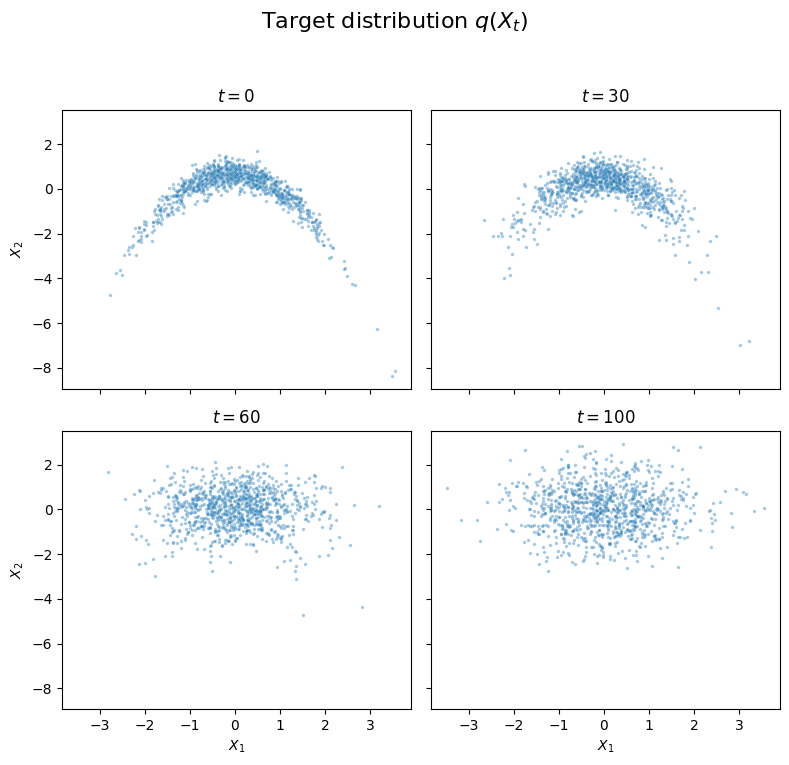

In [15]:
# Task 1: for the given set of T and beta plot the generating distribution q(X_t) for different t=0,30,60,100
# As beta we use the scheme proposed in the lecture
X_0 = Xs

T = 100
ts = np.linspace(0, 1, T + 1)
s = 0.08
gs = np.cos(np.pi / 2 * ((ts + s) / (1 + s))) ** 2
betas = np.minimum(1 - gs[1:] / gs[:-1], 0.999)
# simpler scheme with fixed beta for comparison
# betas = 0.05 * np.ones(T)

# Precompute the alphas using cumulative product
alphas = np.cumprod(np.concatenate((1.0 - betas, [1.0])))


def alpha(t):
    return alphas[t]


fig, axes = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
axes = axes.flatten()
ts = [0, 30, 60, 100]

for idx, t in enumerate(ts):
    X_t = np.random.normal(
        loc=np.sqrt(alpha(t)) * X_0, scale=1.0 - alpha(t), size=(N, 2)
    )
    ax = axes[idx]
    sns.scatterplot(x=X_t[:, 0], y=X_t[:, 1], ax=ax, alpha=0.4, s=6)

    # ax.scatter(X_t[:, 0], X_t[:, 1], alpha=0.4, s=7, color="tab:blue")
    ax.set_title(f"$t={t}$")
    ax.set_xlabel("$X_1$")
    ax.set_ylabel("$X_2$")

fig.suptitle(r"Target distribution $q(X_t)$", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("./figures/target_distribution.png", dpi=600)
plt.show()


In [40]:
# Task 2: implement the loss function for gradient descent (eq 76 in th script, or L_simple in the background material)
# implement by sampling a random time step t in 0,..,T
# params:
#    Xs: a batch of samples from the dataset.
#    model: the model for learning epsilon.


T = 100
ts = torch.linspace(0, 1, T + 1)
s = 0.08
gs = torch.cos(torch.pi / 2 * ((ts + s) / (1 + s))) ** 2
betas = torch.minimum(1 - gs[1:] / gs[:-1], torch.tensor([0.999]))


alphas = torch.cumprod(torch.concatenate((1.0 - betas, torch.tensor([1.0]))), 0)


def alpha(t):
    return torch.tensor(alphas[t])


# mse = torch.nn.MSELoss(reduction="sum")


def loss(Xs, model):
    t = torch.randint(0, T + 1, (1,))  # ToDo should be T+1
    # foo = alpha(t)
    alpha_t = torch.tensor(alpha(t))
    eps_t = torch.randn_like(Xs)
    Xs_with_noise = torch.sqrt(alpha_t) * Xs + torch.sqrt(1.0 - alpha_t) * eps_t
    eps_theta = model(x=Xs_with_noise, t=t)
    mean = torch.mean((eps_t - eps_theta) ** 2)
    return mean
    # mean = mse(eps_t, eps_theta)
    # return mean
    # count = Xs.size(dim=0)
    # print(Xs.shape)
    # t = torch.randint(0, T, (count,))
    # print(t.shape)
    # alpha_t = torch.tensor(alpha(t)).view(-1, 1, 1, 1)
    # print(alpha_t.shape)
    # eps_t = torch.randn_like(Xs)
    # print(eps_t.shape)
    # Xs_noisy = torch.sqrt(alpha_t) * Xs + torch.sqrt(1.0 - alpha_t) * eps_t
    # print(Xs_noisy.shape)
    # eps_theta = model(x=Xs_noisy, t=t)
    # print(eps_theta.shape)
    # mean = torch.mean((eps_t - eps_theta) ** 2)
    # print(mean.shape)
    # return mean
    # return mse(eps_t, eps_theta)


In [28]:
# train loop. added for your convenience.
train_loader = torch.utils.data.DataLoader(
    torch.tensor(Xs, dtype=torch.float32), batch_size=10
)
model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
model.train()
num_epochs = 500
losses = []
for e in tqdm.trange(num_epochs):
    for data in train_loader:
        optimizer.zero_grad()
        l = loss(data, model)
        losses.append(l.detach().item())
        l.backward()
        optimizer.step()

  0%|          | 0/500 [00:00<?, ?it/s]/var/folders/fy/zx0sb02j5rv66mcpx65ldmvc0000gn/T/ipykernel_39988/1079022470.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(alphas[t])
/var/folders/fy/zx0sb02j5rv66mcpx65ldmvc0000gn/T/ipykernel_39988/1079022470.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  alpha_t = torch.tensor(alpha(t))
100%|██████████| 500/500 [00:19<00:00, 26.09it/s]


In [22]:
torch.save(model.state_dict(), "./models/model.pth")

In [ ]:
# model = Net()
# model.load_state_dict(torch.load("./models/model.pth", weights_only=True))
# model.eval()

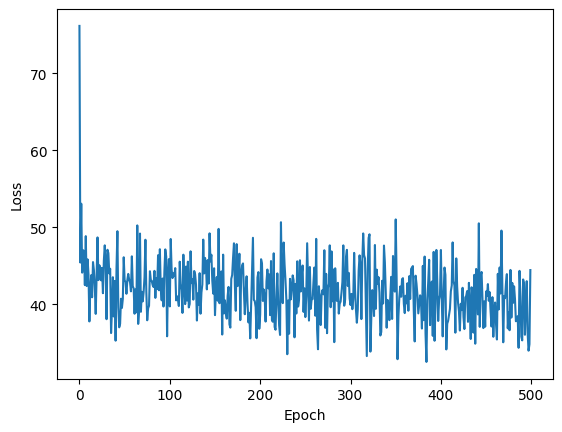

In [29]:
sns.lineplot(
    x=range(num_epochs), y=np.array(losses).reshape(num_epochs, -1).sum(axis=1)
)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("./figures/diffusion_loss.png", dpi=600)
plt.show()

In [39]:
# Task 3: generate samples from the learned model
# num: number of samples to generate
# model: the trained model
def generate_samples(model, num):
    # betas = torch.tensor(betas)
    Xs = torch.normal(0.0, 1.0, size=(num, 2), dtype=torch.float32)
    for t in range(T - 1, -1, -1):
        alpha_t = torch.tensor(alpha(t))
        tt = torch.tensor([t])
        mu = (
            1.0
            / torch.sqrt(1.0 - betas[t])
            * (Xs - betas[t] / torch.sqrt(1.0 - alpha_t) * model(Xs, tt))
        )
        Xs = torch.normal(mu, betas[T - 1] * torch.eye(num, 2))
    return Xs


def generate_samples2(model, num):
    Xs = torch.normal(0.0, 1.0, size=(num, 2), dtype=torch.float32)
    for s in range(1, T):
        t = T - s


generate_samples2(model, 500)

# samples = generate_samples(model, 500).detach().numpy()

# plt.figure()
# plt.scatter(Xs[:, 0], Xs[:, 1], label="truth")
# plt.scatter(samples[:, 0], samples[:, 1], label="generated")
# plt.legend()
# plt.show()

torch.Size([500, 2])
